In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from pandarallel import pandarallel
from tqdm.notebook import tqdm

tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=psutil.cpu_count(logical=False))
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-113-gb7e4ba8-dirty (engine: v0.7.0-102-g1a8ef51-dirty)
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: v0.7.0-102-g1a8ef51-dirty


In [2]:
# Fix model import
import sys
import experiments.train.cfg_model as cfg_model

sys.modules[
    "cfg_model"
] = cfg_model  # cfg_model should be moved somewhere else, I guess

In [3]:
episode_len = 2048
n_episodes = 100
batches = [
    # "2023-01-18_all-protos-0",
    # "2023-01-19_nakamoto-0",
    # "2023-01-19_all-protos-0",
    # "2023-01-20_tailstorm-0",
    # "2023-01-20_tailstorm-discount",
    # "2023-01-23_non-discount-low-alpha",
    # "2023-01-25_bk-8-long-0",  # not so long since I forgot to push the changes before launch
    # "2023-01-25_tailstorm-discount-0",
    # "2023-02-01-alpha50",
    "2023-02-21_ent_coef",
]

protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

# Data generation

## Find trained models

In [4]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)

            ent_coef = 0
            for i, x in enumerate(frag):
                if x.startswith("entcoef"):
                    ent_coef = float(x.removeprefix("entcoef"))
                    frag.pop(i)

            shape = "raw"
            for i, x in enumerate(frag):
                if x in ["raw", "exp", "cut"]:
                    shape = x
                    frag.pop(i)

            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "bkll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "tailstormll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reuse="-")
models

protocol  k    reward subblock_selection  alpha  gamma  ent_coef shape  \
0     nakamoto  1  constant                n/a   0.45   0.95    0.0001   raw   
1    tailstorm  8  constant          heuristic   0.35   0.05    0.0001   raw   
2           bk  8  constant                n/a   0.20   0.05    0.0100   raw   
3    tailstorm  8  constant          heuristic   0.30   0.95    0.0100   raw   
4    tailstorm  8  constant          heuristic   0.20   0.50    0.0010   raw   
..         ... ..       ...                ...    ...    ...       ...   ...   
928  tailstorm  8  constant          heuristic   0.20   0.95    0.0010   raw   
929  tailstorm  8  constant          heuristic   0.30   0.05    0.0001   raw   
930   nakamoto  1  constant                n/a   0.25   0.95    0.0010   raw   
931   nakamoto  1  constant                n/a   0.30   0.50    0.0001   raw   
932  tailstorm  8  discount          heuristic   0.40   0.05    0.0001   raw   

                policy                                               path  \
0    ppo-6vu6b9w6-best  data/models/2023-02-21_ent_coef/ppo-nakamoto-a...   
1    ppo-pia2ch4q-best  data/models/2023-02-21_ent_coef/ppo-tailstorm-...   
2    ppo-wujmdcos-best  data/models/2023-02-21_ent_coef/ppo-bk-8-alpha...   
3       ppo-2wq4ya3o_2  data/models/2023-02-21_ent_coef/ppo-tailstorm-...   
4       ppo-n3f08wh3_2  data/models/2023-02-21_ent_coef/ppo-tailstorm-...   
..                 ...                                                ...   
928  ppo-v6h02472-best  data/models/2023-02-21_ent_coef/ppo-tailstorm-...   
929     ppo-rur37a6k_2  data/models/2023-02-21_ent_coef/ppo-tailstorm-...   
930     ppo-k0yg4i11_2  data/models/2023-02-21_ent_coef/ppo-nakamoto-a...   
931     ppo-iyr0nm0a_2  data/models/2023-02-21_ent_coef/ppo-nakamoto-a...   
932  ppo-2krr9lqa-best  data/models/2023-02-21_ent_coef/ppo-tailstorm-...   

        kind reuse  
0    trained     -  
1    trained     -  
2    trained     -  
3    trained     -  
4    trained     -  
..       ...   ...  
928  trained     -  
929  trained     -  
930  trained     -  
931  trained     -  
932  trained     -  

[933 rows x 12 columns]

In [5]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reuse="proto", reward="discount"
        ),
        models.query("gamma != 0.05").assign(reuse="gamma05", gamma=0.05),
        models.query("gamma != 0.50").assign(reuse="gamma50", gamma=0.50),
        models.query("gamma != 0.95").assign(reuse="gamma95", gamma=0.95),
    ]
)
models = models.assign(reused=[x != "-" for x in models.reuse])
# models

## Find hard-coded policies

In [6]:
def hard_coded_policies(models):
    for _idx, x in (
        models[["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]]
        .drop_duplicates()
        .iterrows()
    ):
        kwargs = env_kwargs_of_row(x)
        env = gym.make(env_name, **kwargs)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reuse="-", reused=False)
)
hard_coded_policies
# hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

protocol  k    reward subblock_selection  gamma  alpha  \
0     nakamoto  1  constant                n/a   0.95   0.45   
1     nakamoto  1  constant                n/a   0.95   0.45   
2     nakamoto  1  constant                n/a   0.95   0.45   
3     nakamoto  1  constant                n/a   0.95   0.45   
4    tailstorm  8  constant          heuristic   0.05   0.35   
..         ... ..       ...                ...    ...    ...   
289         bk  8  constant                n/a   0.05   0.40   
290         bk  8  constant                n/a   0.50   0.50   
291         bk  8  constant                n/a   0.50   0.50   
292         bk  8  constant                n/a   0.95   0.40   
293         bk  8  constant                n/a   0.95   0.40   

                   policy        kind path reuse  reused  
0    sapirshtein-2016-sm1  hard-coded  n/a     -   False  
1         eyal-sirer-2014  hard-coded  n/a     -   False  
2                  simple  hard-coded  n/a     -   False  
3                  honest  hard-coded  n/a     -   False  
4              avoid-loss  hard-coded  n/a     -   False  
..                    ...         ...  ...   ...     ...  
289                honest  hard-coded  n/a     -   False  
290               selfish  hard-coded  n/a     -   False  
291                honest  hard-coded  n/a     -   False  
292               selfish  hard-coded  n/a     -   False  
293                honest  hard-coded  n/a     -   False  

[294 rows x 11 columns]

## Run simulations

In [7]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)


def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    if x.kind == "trained":
        res = cached.measure_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = cached.measure_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


d = episodes.sample(
    frac=1
)  # shuffle for better load balancing in case of cached measurements

# results = d.progress_apply(measure_row, axis=1)
with threadpoolctl.threadpool_limits(limits=1):
    results = d.parallel_apply(measure_row, axis=1)

episodes = pd.concat([d, results], axis=1).sort_index()

# list(episodes.columns)

In [8]:
# save episode data for re-use in other notebooks
episodes.to_pickle("experiments/rl-eval/episodes.pkl")

# Find optimal policies

In [9]:
scenario = [
    "protocol",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
# d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

protocol  k    reward subblock_selection  alpha  gamma        kind  \
0           bk  8  constant                n/a    0.2   0.05  hard-coded   
1           bk  8  constant                n/a    0.2   0.05     trained   
2           bk  8  constant                n/a    0.2   0.05     trained   
3           bk  8  constant                n/a    0.2   0.50  hard-coded   
4           bk  8  constant                n/a    0.2   0.50     trained   
..         ... ..       ...                ...    ...    ...         ...   
246  tailstorm  8  discount          heuristic    0.5   0.50     trained   
247  tailstorm  8  discount          heuristic    0.5   0.50     trained   
248  tailstorm  8  discount          heuristic    0.5   0.95  hard-coded   
249  tailstorm  8  discount          heuristic    0.5   0.95     trained   
250  tailstorm  8  discount          heuristic    0.5   0.95     trained   

     reused             policy  
0     False             honest  
1     False  ppo-ub5mebn8-best  
2      True  ppo-r73btgb2-best  
3     False             honest  
4     False  ppo-927a42kr-best  
..      ...                ...  
246   False  ppo-rd33ahe8-best  
247    True  ppo-2gamo0zy-best  
248   False        minor-delay  
249   False  ppo-ijtjbhmp-best  
250    True  ppo-jlwm4xoj-best  

[251 rows x 9 columns]

# Compare RL against best hard-coded

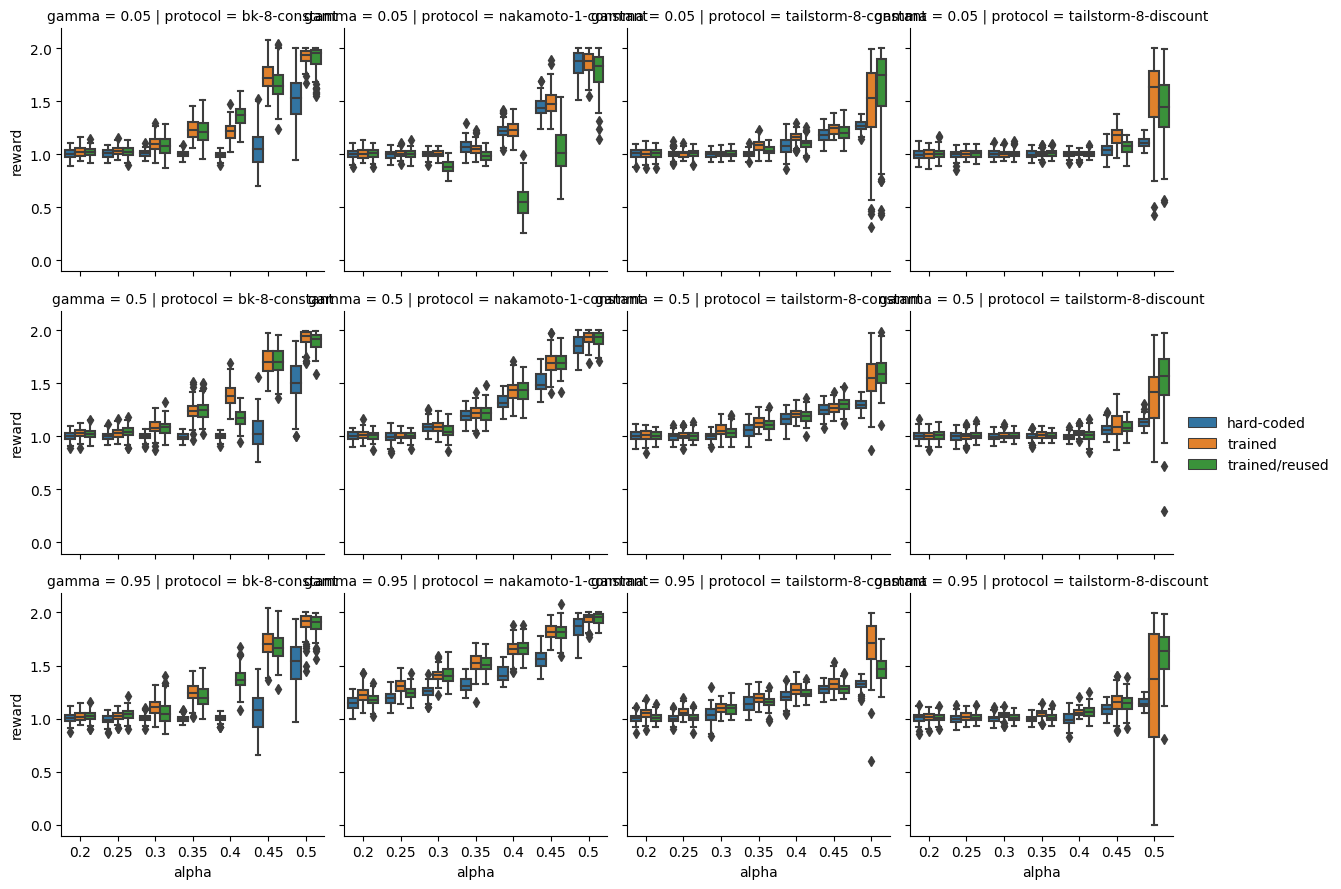

In [10]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="protocol",
        row="gamma",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette=sns.color_palette(),
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

In [11]:
opt_policies.query('protocol == "tailstorm" and gamma==0.95 and alpha==.45').drop(
    columns=["path"]
)

protocol  k    reward subblock_selection  alpha  gamma        kind  \
176  tailstorm  8  constant          heuristic   0.45   0.95  hard-coded   
177  tailstorm  8  constant          heuristic   0.45   0.95     trained   
178  tailstorm  8  constant          heuristic   0.45   0.95     trained   
239  tailstorm  8  discount          heuristic   0.45   0.95  hard-coded   
240  tailstorm  8  discount          heuristic   0.45   0.95     trained   
241  tailstorm  8  discount          heuristic   0.45   0.95     trained   

     reused             policy  
176   False        minor-delay  
177   False  ppo-ha8ook2p-best  
178    True     ppo-5r4m6xp7_2  
239   False        minor-delay  
240   False  ppo-7l4rhx8x-best  
241    True     ppo-ha8ook2p_2

/tmp/ipykernel_47770/3968487956.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


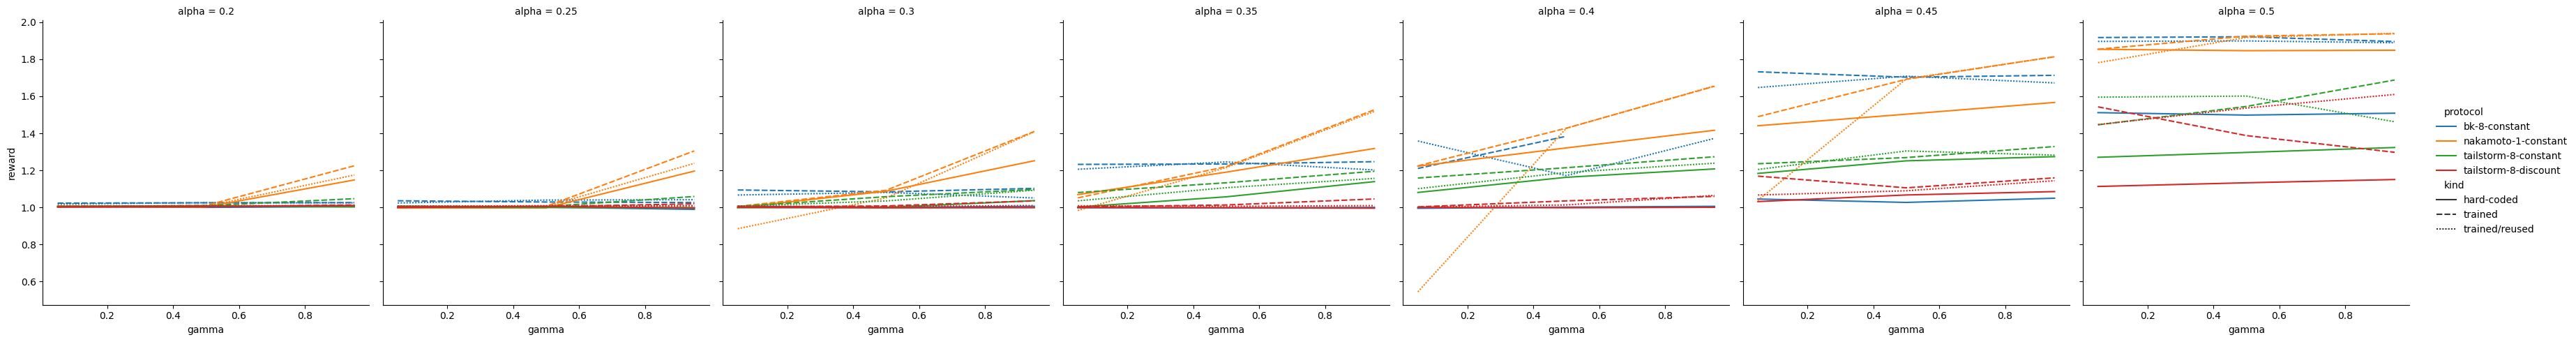

In [12]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

/tmp/ipykernel_47770/4159778813.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


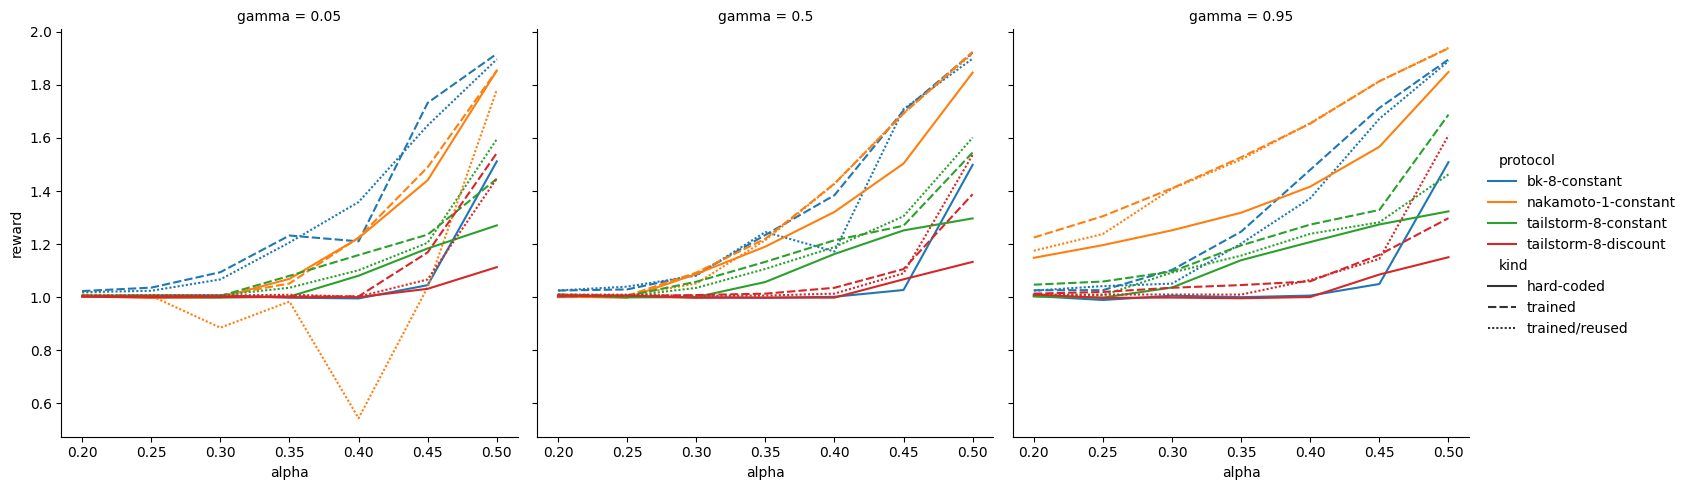

In [13]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

# Honest or Attack?

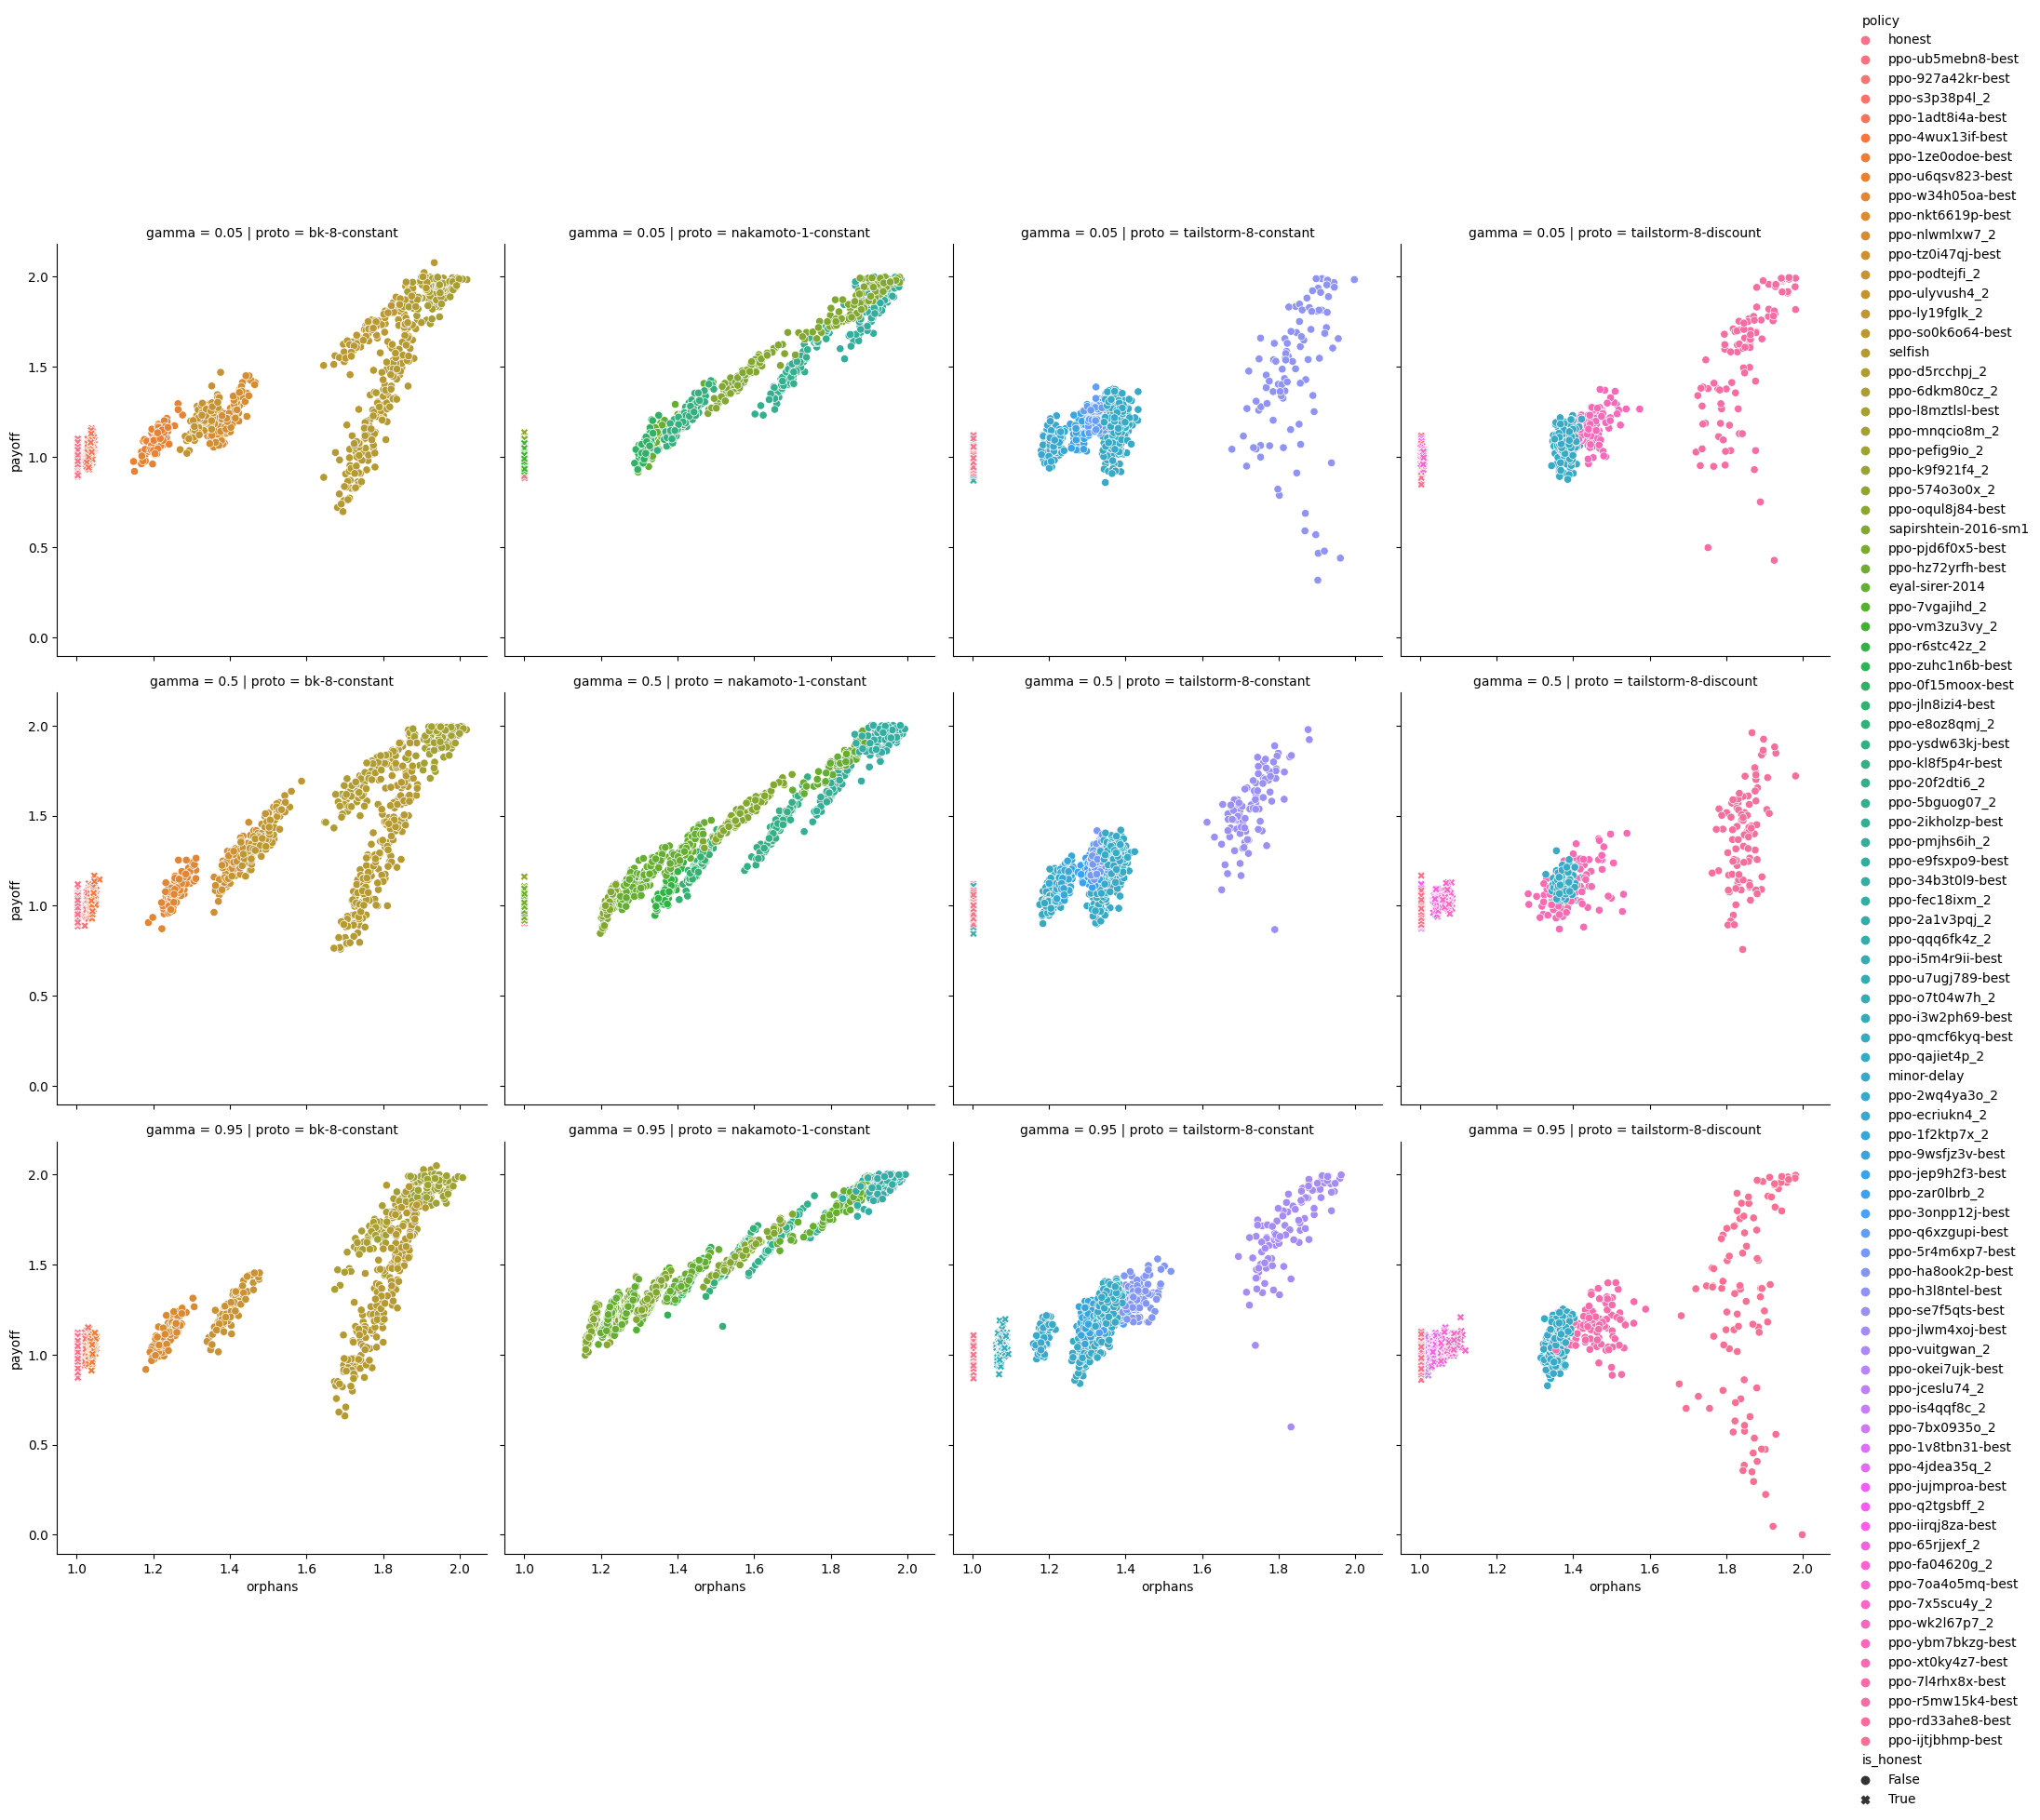

In [14]:
grouping = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "policy"]
d = opt_episodes.query("not reused")
d = d.assign(
    orphans=d.episode_n_activations / d.episode_progress,
    proto=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    payoff=d.episode_reward_attacker / d.episode_progress / d.alpha,
)
dd = d.groupby(grouping).agg(
    mean_orphans=("orphans", "mean"),
    mean_payoff=("payoff", "mean"),
    std_payoff=("payoff", "std"),
)
d = d.set_index(grouping + ["episode"]).join(dd).reset_index()
d = d.assign(is_honest=d.mean_orphans <= 1.15)
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="policy",
    style="is_honest",
    row="gamma",
    col="proto",
)
honest_or_attack_episodes = d  # for later use
# list(d.columns)

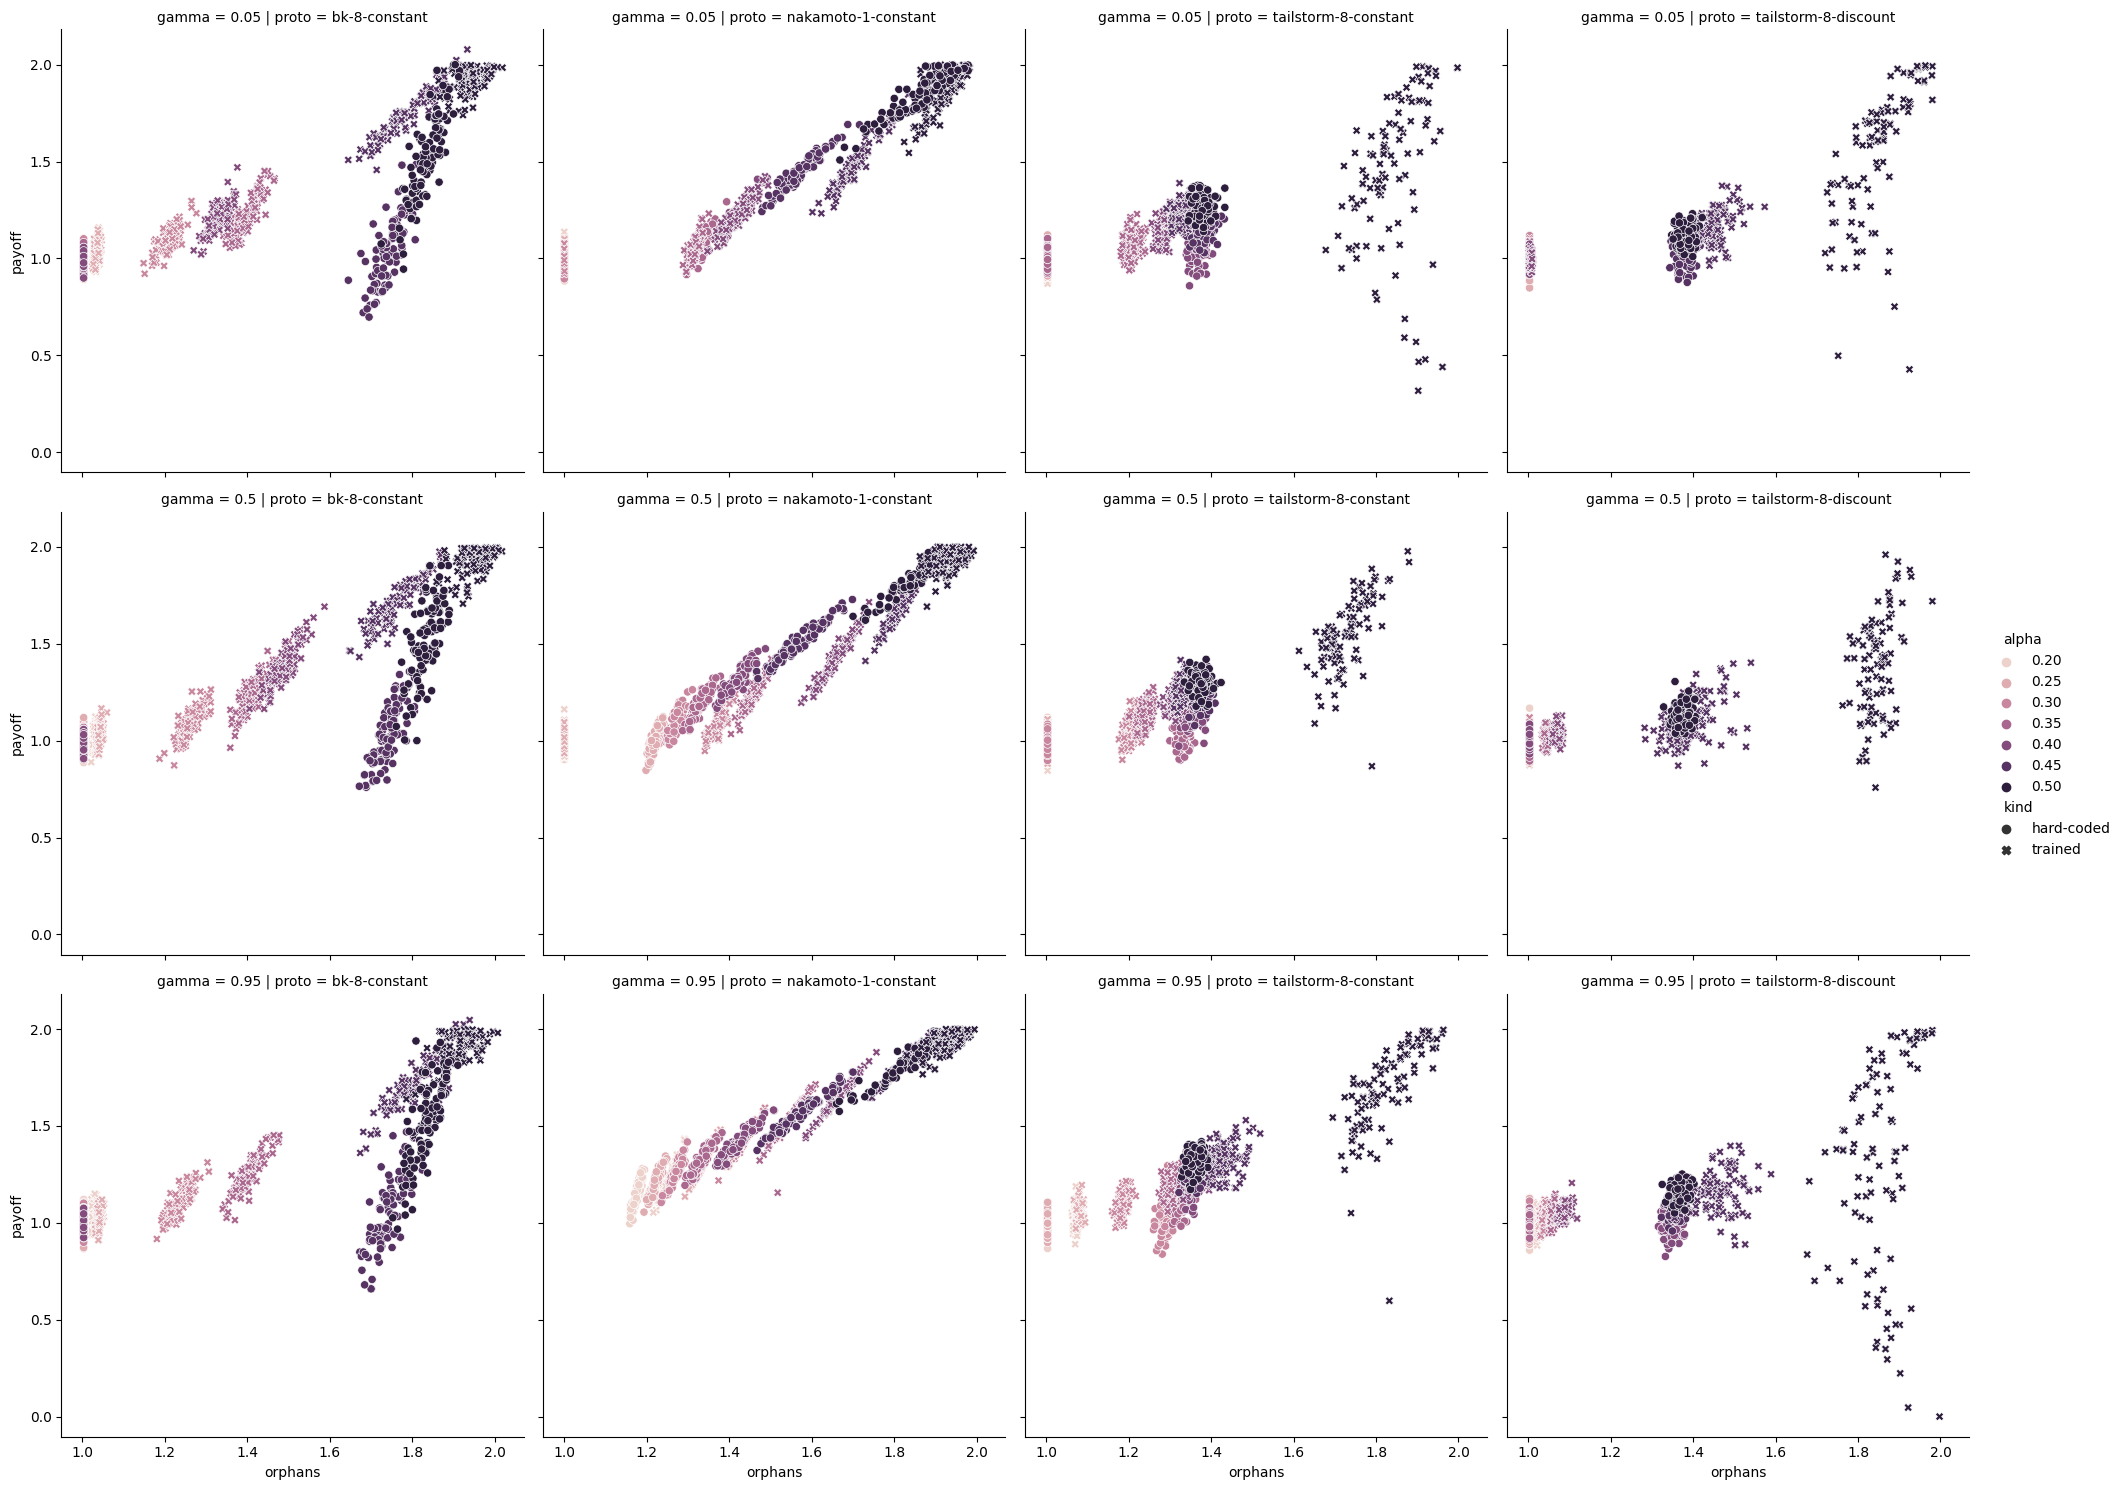

In [15]:
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

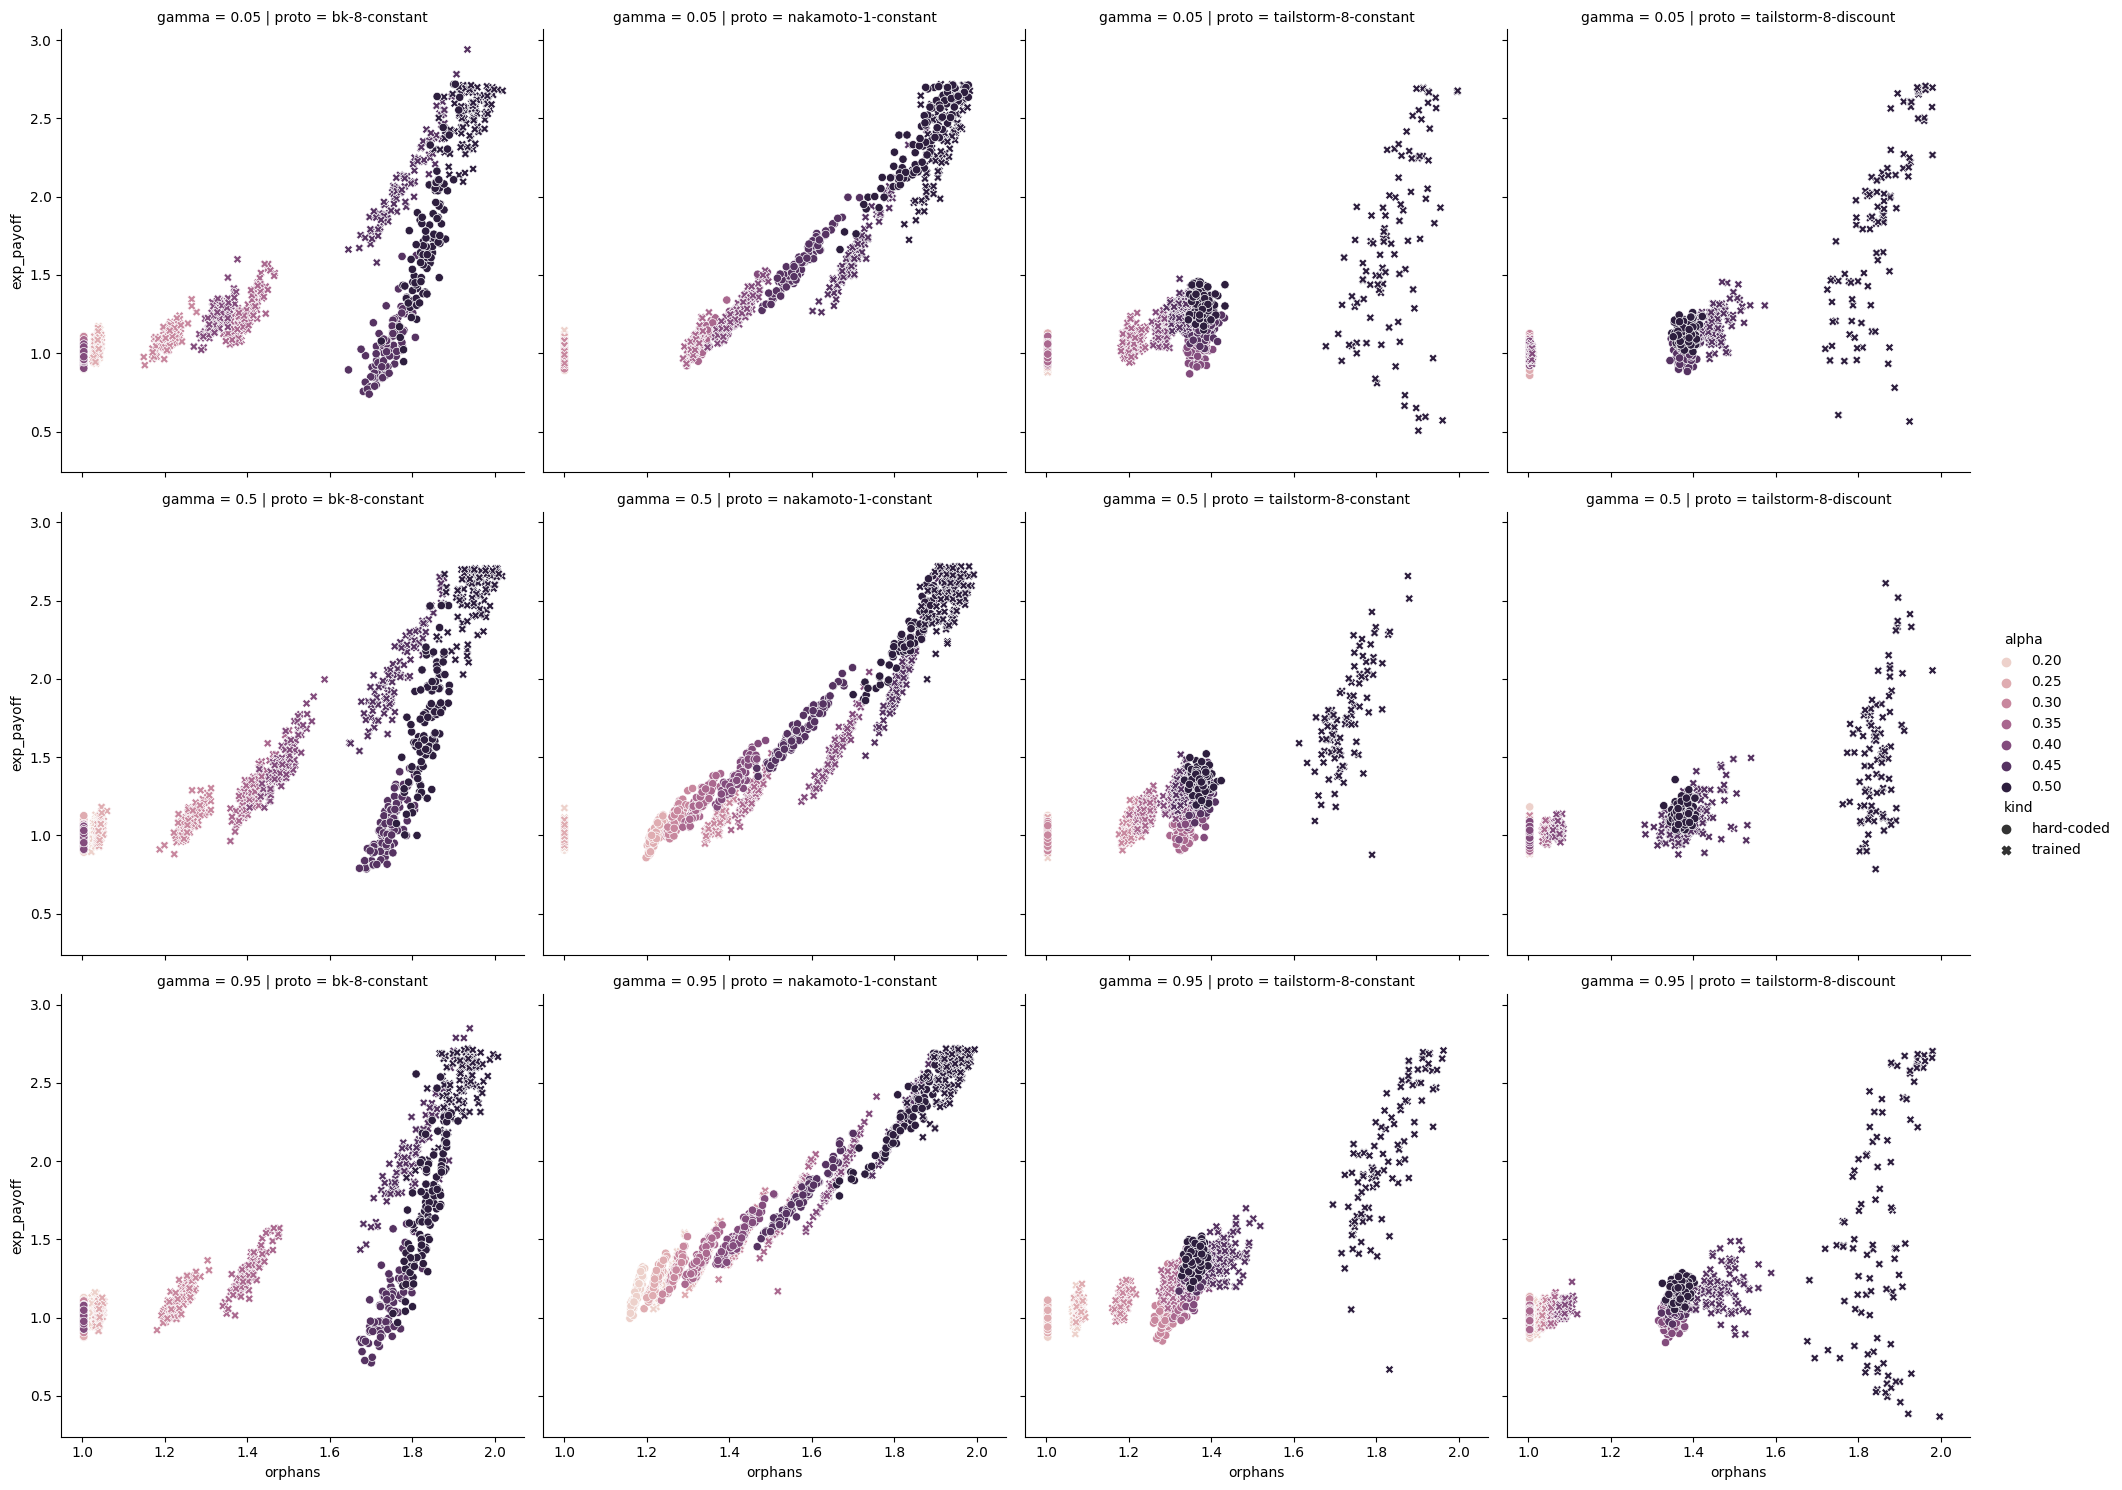

In [16]:
sns.relplot(
    data=d.assign(exp_payoff=np.exp(d.payoff - 1)),
    x="orphans",
    y="exp_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

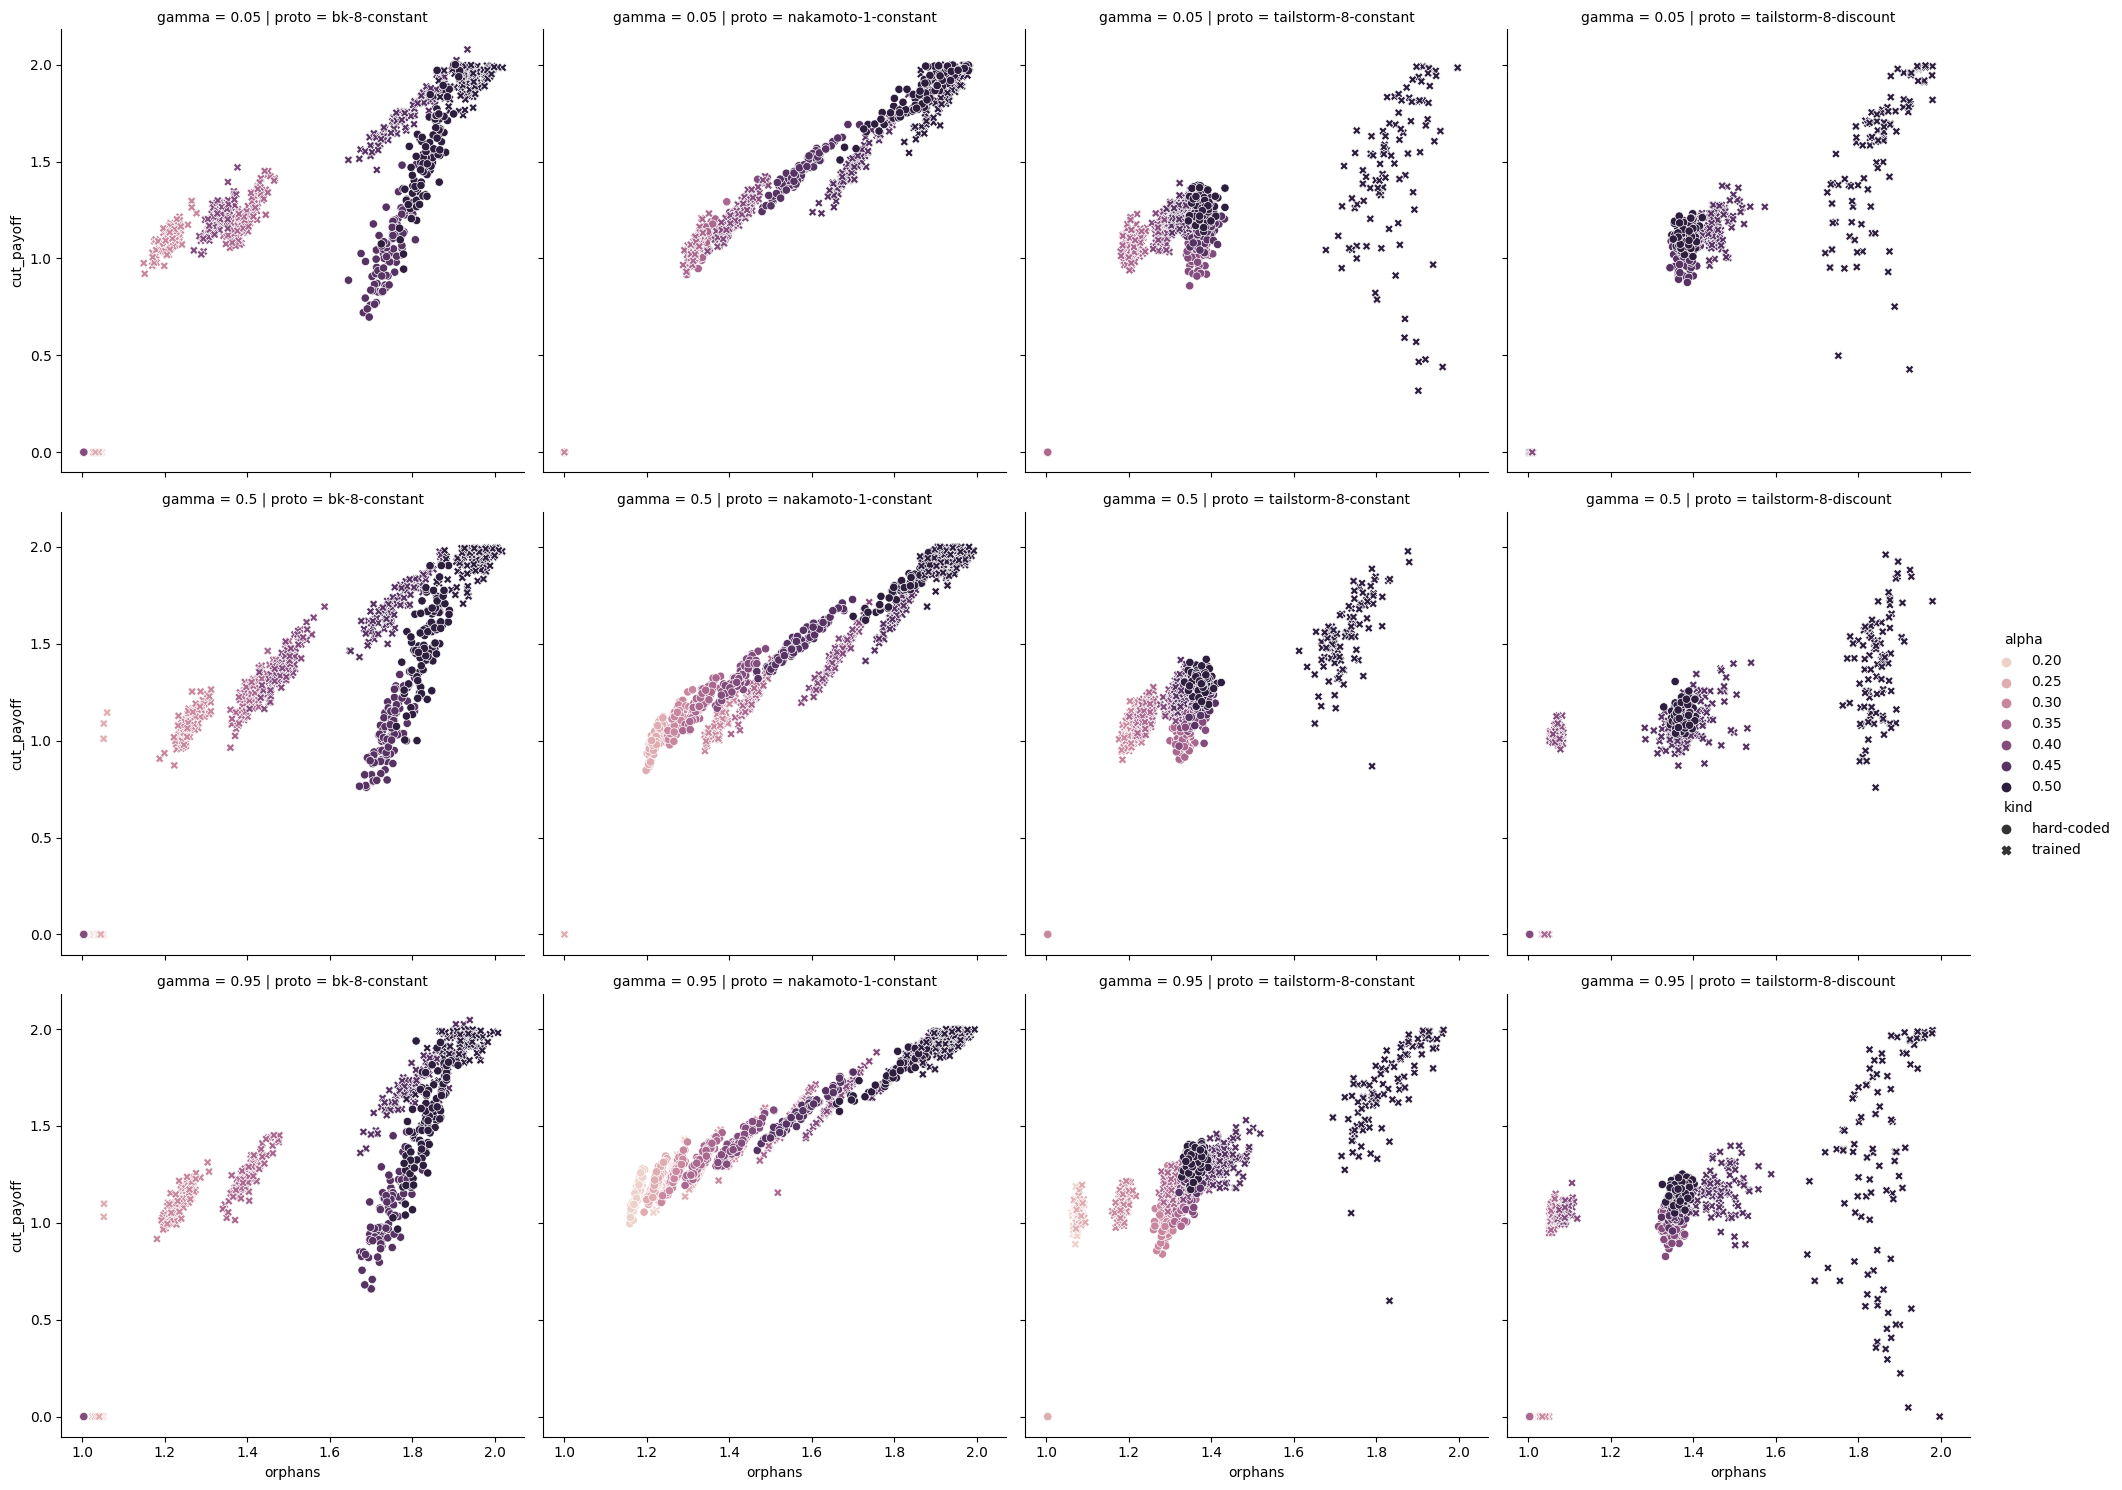

In [17]:
sns.relplot(
    data=d.assign(
        cut_payoff=[x.payoff if x.orphans > 1.05 else 0 for _, x in d.iterrows()]
    ),
    x="orphans",
    y="cut_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [18]:
grouping = ["protocol", "k", "reward", "subblock_selection", "gamma", "kind"]
select = ["policy", "reused", "path"]
d = honest_or_attack_episodes.query("is_honest == False and reused==False")
d = d[grouping + ["alpha"] + select].drop_duplicates().reset_index(drop=True)
d = d.loc[d.groupby(grouping).alpha.idxmin()].reset_index(drop=True)
be_policies = d
display(be_policies.drop(columns="path"))

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.45   
1          bk  8  constant                n/a   0.05     trained   0.30   
2          bk  8  constant                n/a   0.50  hard-coded   0.45   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.45   
5          bk  8  constant                n/a   0.95     trained   0.30   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.35   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.30   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.45   

                  policy  reused  
0                selfish   False  
1      ppo-u6qsv823-best   False  
2                selfish   False  
3      ppo-w34h05oa-best   False  
4                selfish   False  
5      ppo-nkt6619p-best   False  
6        eyal-sirer-2014   False  
7      ppo-0f15moox-best   False  
8   sapirshtein-2016-sm1   False  
9         ppo-r6stc42z_2   False  
10  sapirshtein-2016-sm1   False  
11     ppo-oqul8j84-best   False  
12           minor-delay   False  
13        ppo-ecriukn4_2   False  
14           minor-delay   False  
15        ppo-qajiet4p_2   False  
16           minor-delay   False  
17        ppo-2wq4ya3o_2   False  
18           minor-delay   False  
19     ppo-ybm7bkzg-best   False  
20           minor-delay   False  
21     ppo-xt0ky4z7-best   False  
22           minor-delay   False  
23     ppo-7l4rhx8x-best   False

In [19]:
import break_even


def find_break_even_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = 8192  # quality of each point
    kwargs["n_calls"] = 42  # how many points
    kwargs[
        "title"
    ] = f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    if x.kind == "trained":
        res = break_even.find_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = break_even.find_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[2]]
d = be_policies

# results = d.progress_apply(find_break_even_row, axis = 1)
with threadpoolctl.threadpool_limits(limits=1):
    results = d.parallel_apply(find_break_even_row, axis=1)
be_points = pd.concat([d, results], axis=1)

In [20]:
be_points.drop(columns=["path", "break_even_png"])

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.45   
1          bk  8  constant                n/a   0.05     trained   0.30   
2          bk  8  constant                n/a   0.50  hard-coded   0.45   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.45   
5          bk  8  constant                n/a   0.95     trained   0.30   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.35   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.30   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.45   

                  policy  reused  break_even  
0                selfish   False    0.440664  
1      ppo-u6qsv823-best   False    0.200778  
2                selfish   False    0.443002  
3      ppo-w34h05oa-best   False    0.260782  
4                selfish   False    0.441819  
5      ppo-nkt6619p-best   False    0.228349  
6        eyal-sirer-2014   False    0.334139  
7      ppo-0f15moox-best   False    0.332665  
8   sapirshtein-2016-sm1   False    0.246560  
9         ppo-r6stc42z_2   False    0.263583  
10  sapirshtein-2016-sm1   False    0.100000  
11     ppo-oqul8j84-best   False    0.100000  
12           minor-delay   False    0.373291  
13        ppo-ecriukn4_2   False    0.301717  
14           minor-delay   False    0.330425  
15        ppo-qajiet4p_2   False    0.271232  
16           minor-delay   False    0.278591  
17        ppo-2wq4ya3o_2   False    0.182802  
18           minor-delay   False    0.440464  
19     ppo-ybm7bkzg-best   False    0.393809  
20           minor-delay   False    0.413139  
21     ppo-xt0ky4z7-best   False    0.397491  
22           minor-delay   False    0.394154  
23     ppo-7l4rhx8x-best   False    0.394377

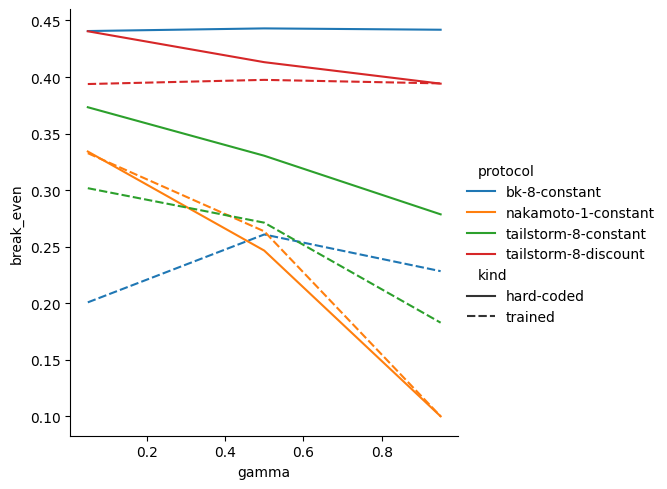

In [21]:
d = be_points.copy()
d.loc[d.reused, "kind"] = "trained/reused"
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    ),
    kind="line",
    hue="protocol",
    x="gamma",
    y="break_even",
    style="kind",
)

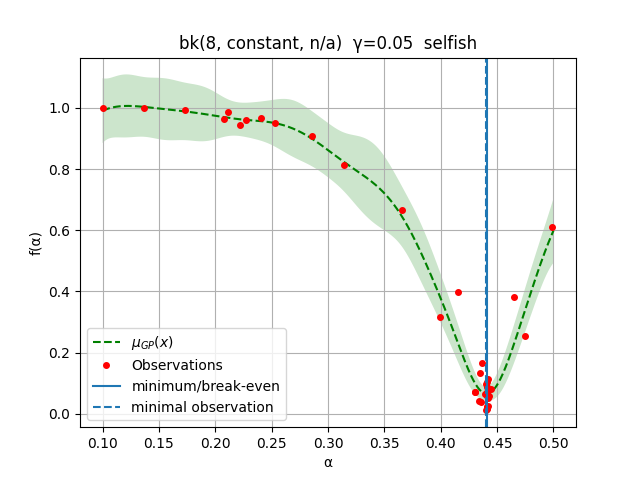

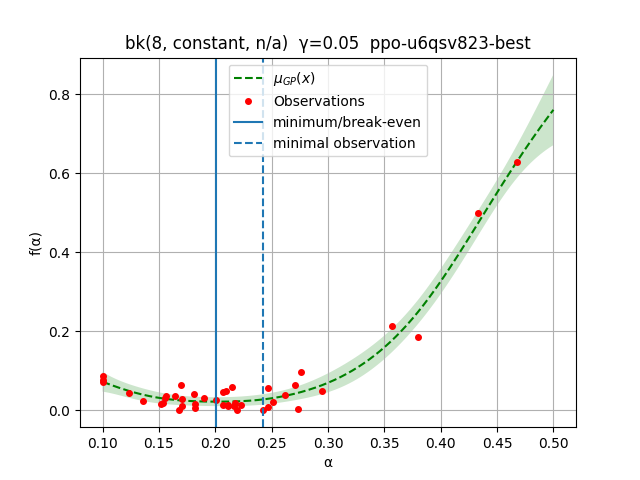

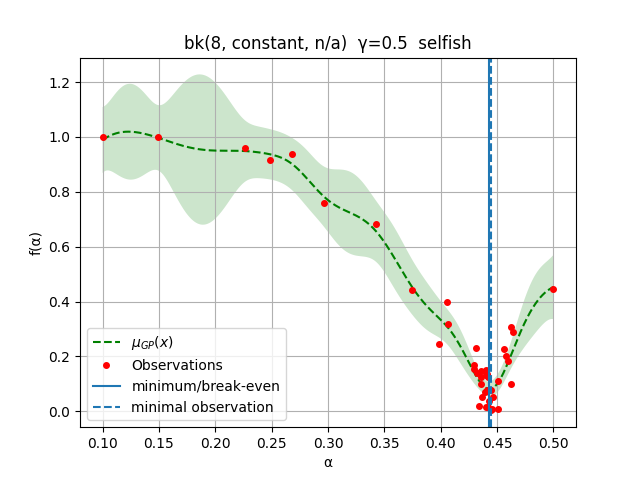

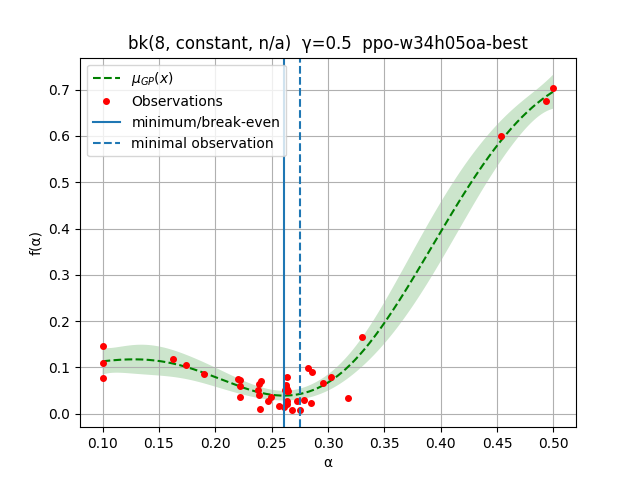

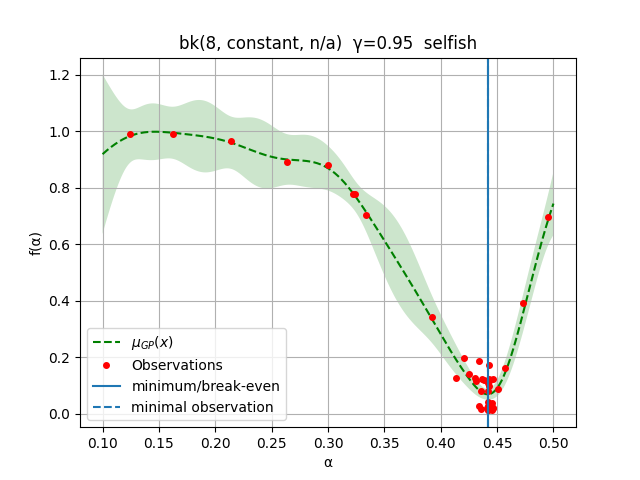

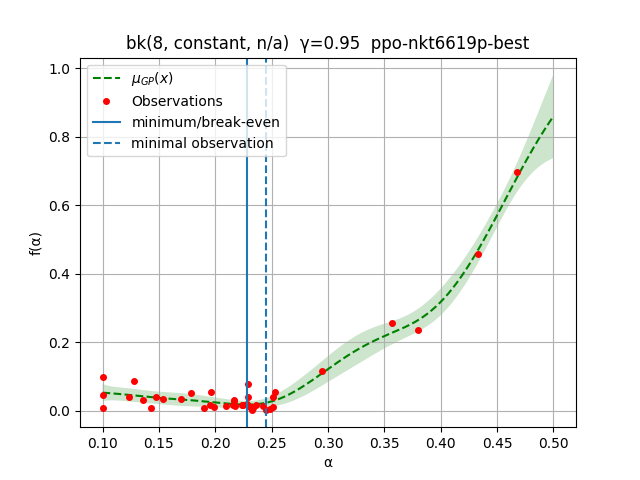

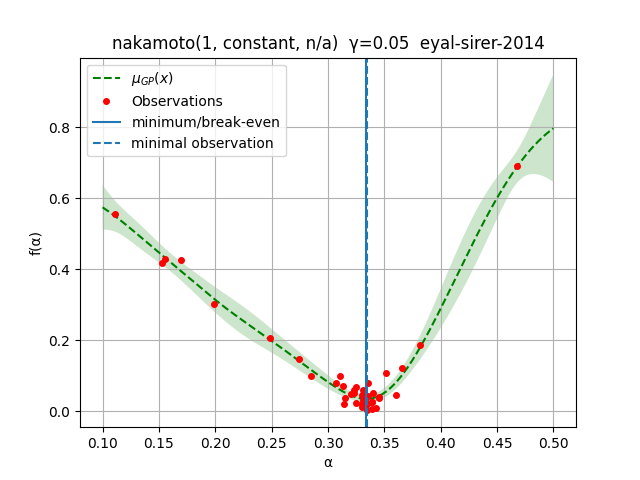

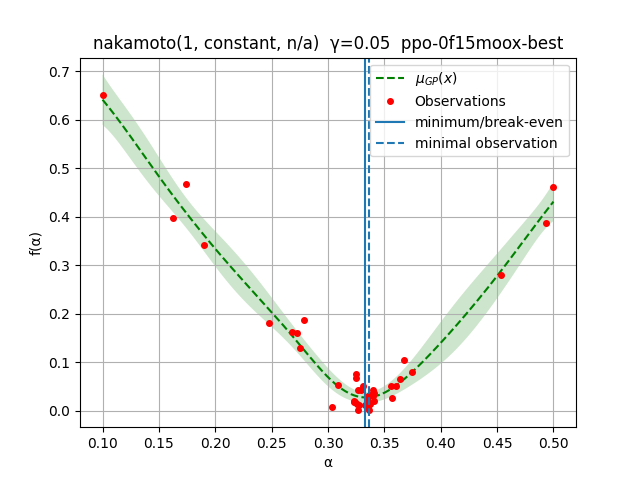

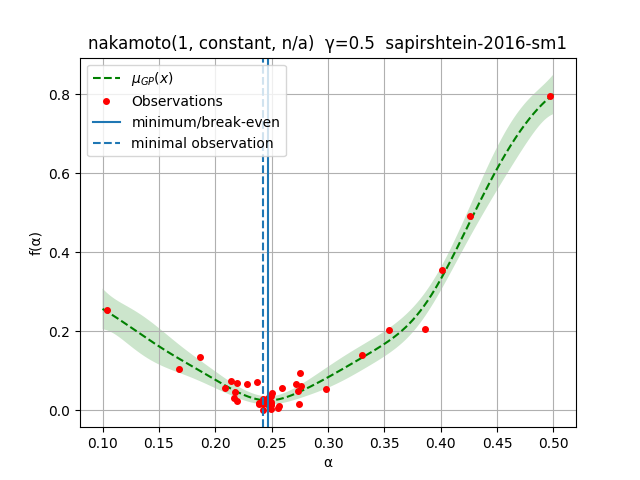

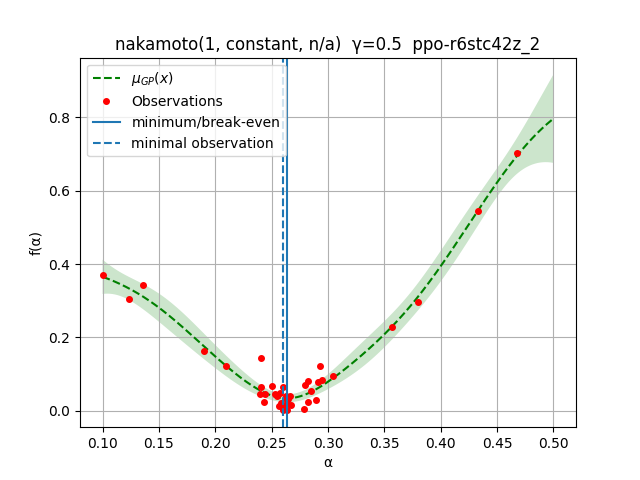

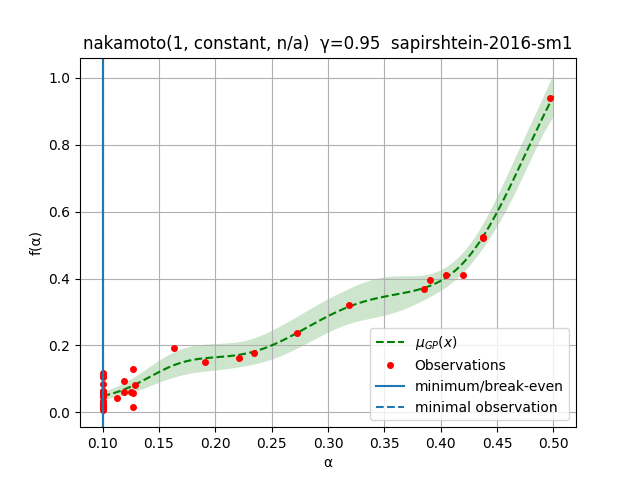

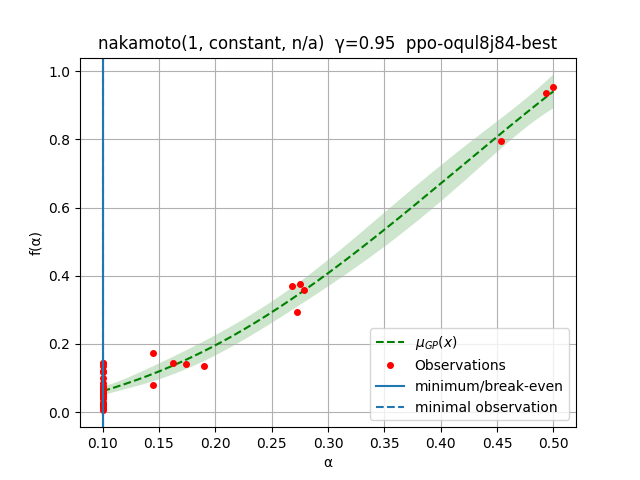

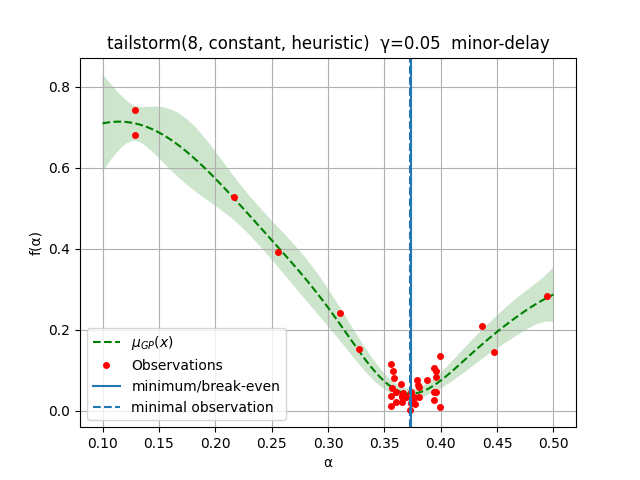

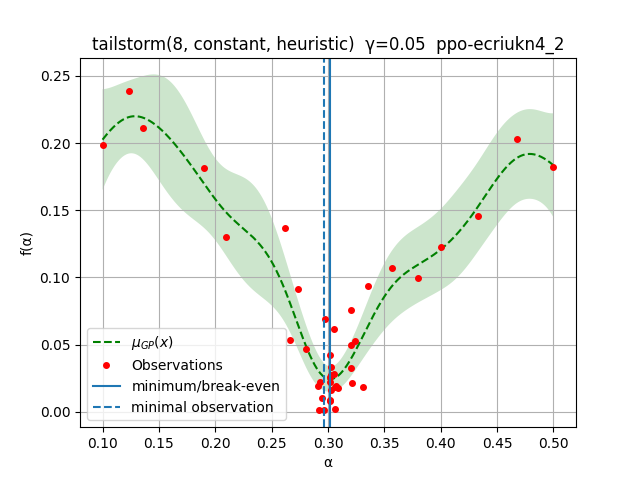

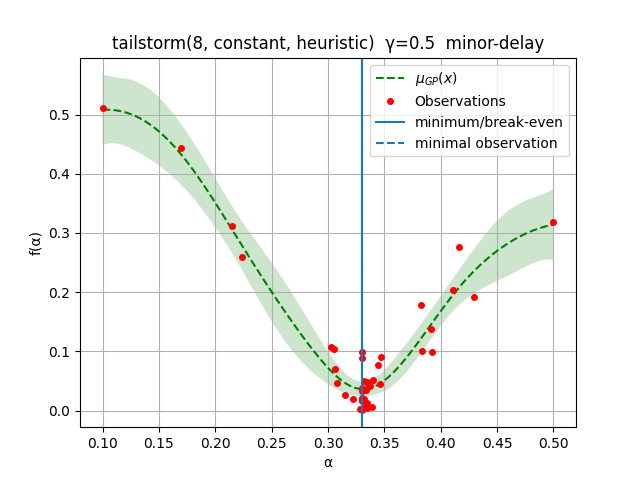

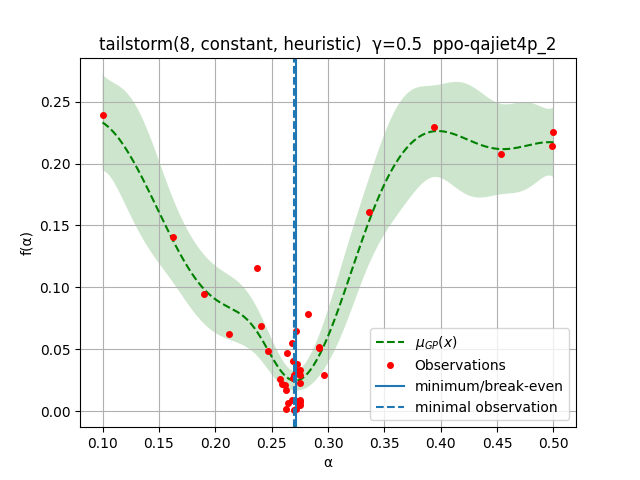

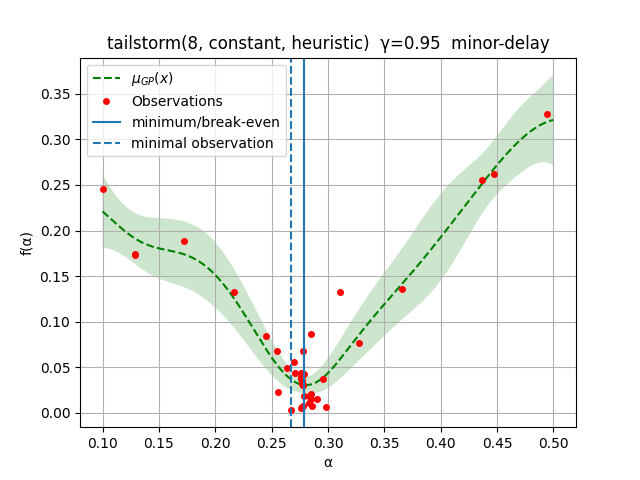

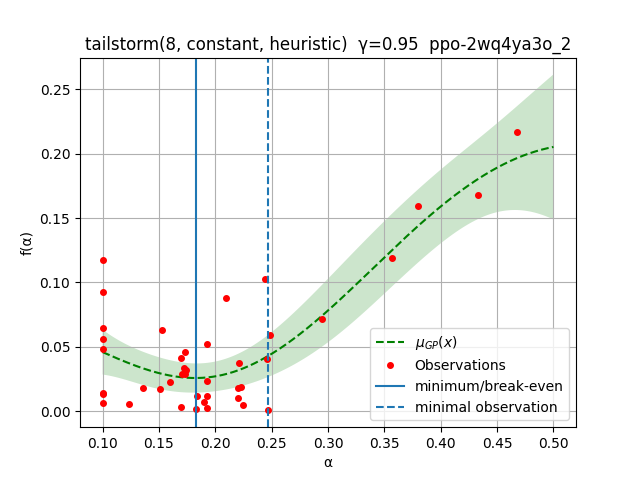

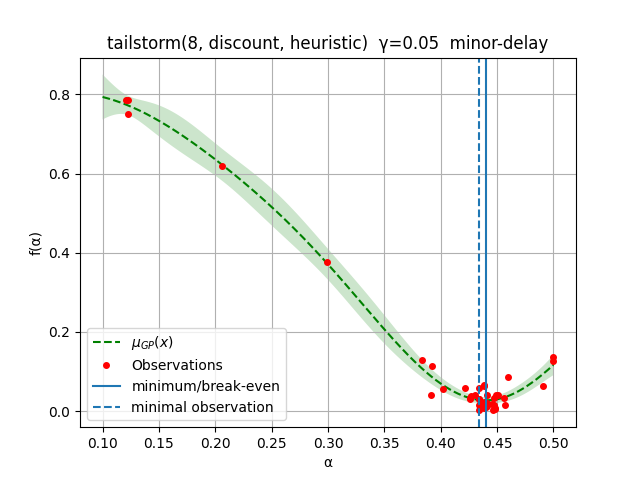

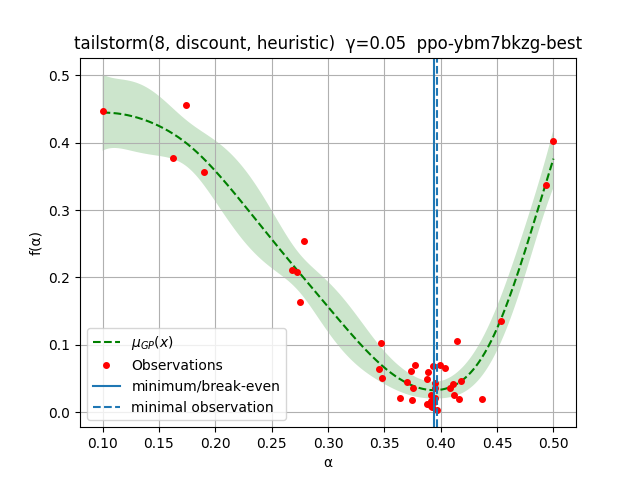

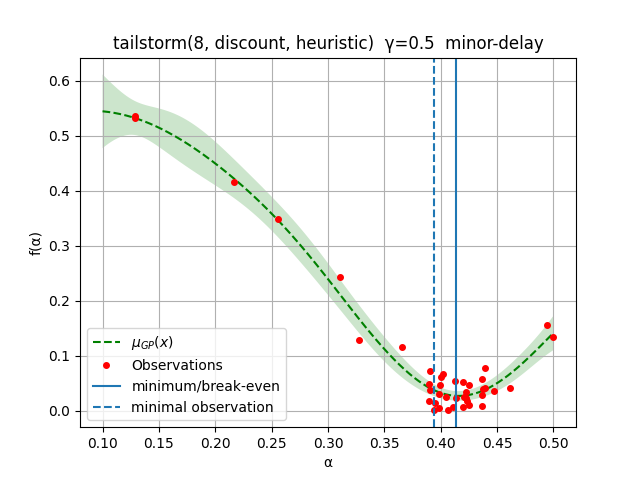

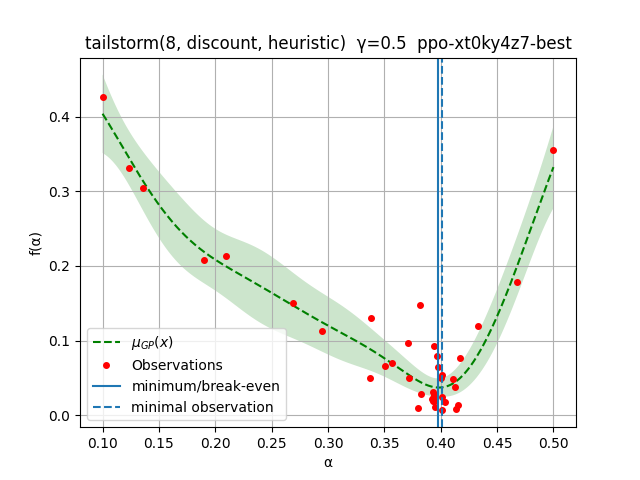

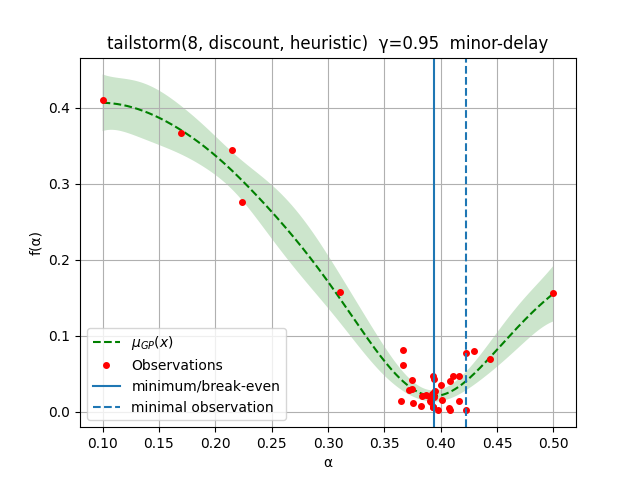

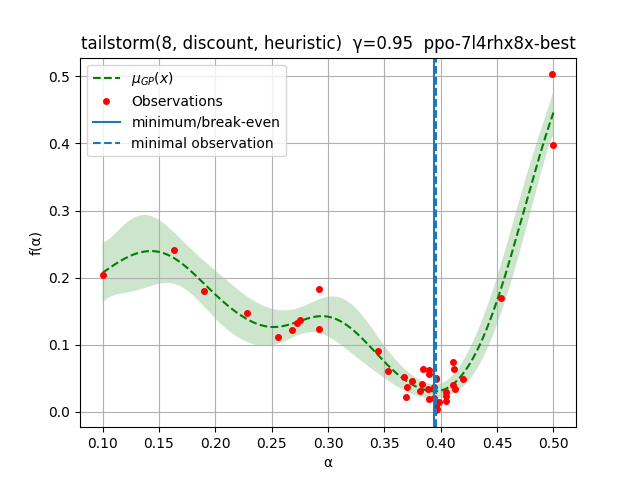

In [22]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)